In [2]:
import pandas as pd
import numpy as np
import keras
import matplotlib
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, TimeDistributed, Activation
import matplotlib.pylab as plt
from keras.utils import to_categorical
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding, Input
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


A function with random sine functions overlapping. From the plot below it can be seen multiple sine functions create random effects. This work is to see how good RNN architecture can predict random structures

In [0]:
def func_rand(xin, period_list):
    res = np.zeros(xin.shape)
    for period in period_list:
        res += np.sin(np.pi * xin / period)
    return res

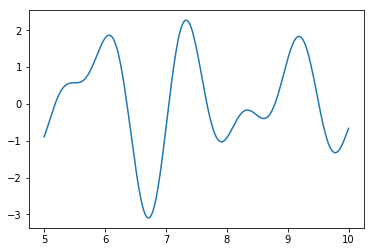

In [4]:
pr_list_exp = [0.5, 0.7, 0.9, 1.1, 1.3]
x = np.linspace(5, 10, 300)
plt.plot(x, func_rand(x, pr_list_exp))

Generate input data With only chosable number of sine functions in it

In [0]:
def generate_data(length=100, nsplit=2000, pre=20, 
                  pr_list=[0.5, 0.7, 0.9, 1.1, 1.3]):
    t_start = 50
    t_end = t_start + length
    timeseries = np.linspace(t_start, t_end, nsplit)
    values = func_rand(timeseries, pr_list)
    post = pre
    X_pre = []
    y_post = []
    for i in range(len(timeseries) - pre - post - 1):
        X_pre.append(values[i:i+pre])
        y_post.append(values[i+pre:i+pre+post])

    X_pre = np.array(X_pre)
    y_post = np.array(y_post)
    X_in = pd.DataFrame(X_pre)
    y_in = pd.DataFrame(y_post)
    
    X_pre = np.reshape(X_pre, (X_in.shape[0], X_in.shape[1], 1))
    y_post = np.reshape(y_post, (y_post.shape[0], y_post.shape[1], 1))
    
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_pre, y_post, test_size=0.20, random_state=23)
    return X_train, X_valid, y_train, y_valid

Test function

In [0]:
def test_output(model, pr_list, pre, length, nsplit, 
                test_start_loc=1000, start_id = 120):
    post = pre
    x_test_in = np.linspace(test_start_loc, test_start_loc + length, nsplit)
    values_test_in = func_rand(x_test_in, pr_list)
    values_input = values_test_in[start_id:pre + start_id]
    values_ouput = values_test_in[start_id + pre:pre + post + start_id]
    values_input_np = np.reshape(values_input, (1, pre, 1))
    result = model.predict(values_input_np, verbose=0)
    return x_test_in[start_id:pre + post + start_id], \
    np.hstack((values_input, values_ouput)), \
    np.hstack((values_input, result.flatten()))

In [0]:
def clusters(pr_list, parameters=(2000, 100, 50)):
    nsplit = parameters[0]
    length = parameters[1]
    pre = parameters[2]
    post = pre
    # looking back length = pre / nsplit * length
    look_back = pre / nsplit * length
    print('looking back of length : ' + str(look_back))
    print('period list is ' + str(pr_list))
    X_train, X_valid, y_train, y_valid = \
        generate_data(length=length, nsplit=nsplit, 
                      pre=pre, pr_list=pr_list)
    
    model_1 = Sequential()  
    model_1.add(LSTM(150, input_shape=(pre, 1), return_sequences=True))  
    model_1.add(TimeDistributed(Dense(1)))
    model_1.add(Activation('linear'))   
    model_1.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mean_squared_error'])
    callbacks_1 = [EarlyStopping(monitor='val_loss', patience=10)]
    model_1.fit(X_train,  y_train, batch_size=4096, epochs=100, callbacks=callbacks_1,
              validation_data=(X_valid, y_valid), verbose=0)
    
    fig, axes = plt.subplots(1, 4)
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(15, 4)
    fig.suptitle('Looking back length = ' + str(look_back))
    axes = axes.flatten()
    for ax in axes:
        x, y1, y2 = test_output(model_1, pr_list, pre, length, nsplit,
                                test_start_loc=np.random.randint(1000, 2000), 
                                start_id = np.random.randint(0, 500))
        ax.plot(x, y1)
        ax.plot(x, y2)
        ax.text(np.min(x), (np.min(y1) + np.max(y1)) / 2, 'mse=' + '{0:.7f}'.format(mean_squared_error(y1, y2)))
        
    

With only one sine function, period list = [0.5]

It can be seen that the prediction works pretty well

looking back of length : 2.5
period list is [0.5]




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




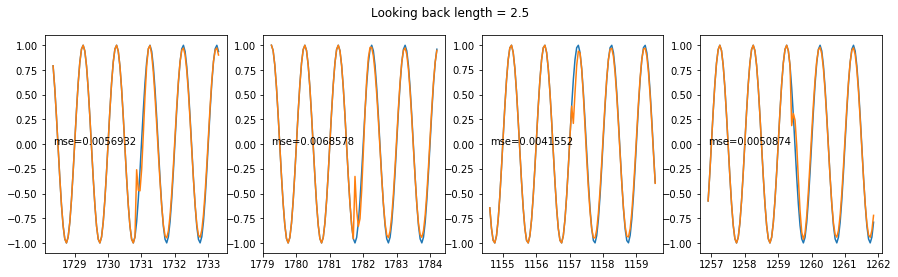

In [8]:
clusters([0.5])

With only one sine function, period list = [0.5, 0.7, 0.9]

The MSE is a little higher than the simple case

looking back of length : 2.5
period list is [0.5, 0.7, 0.9]


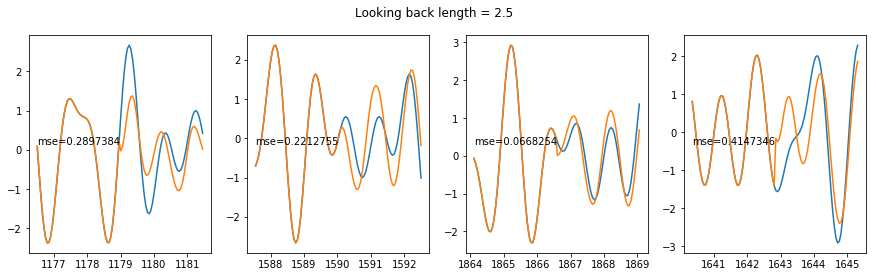

In [9]:
clusters([0.5, 0.7, 0.9])

With only one sine function, period list = [0.5, 0.7, 0.9], but longer look_back steps. It took longer time to train.

With this added in, the mse generally decreases a little bit.

looking back of length : 5.0
period list is [0.5, 0.7, 0.9]


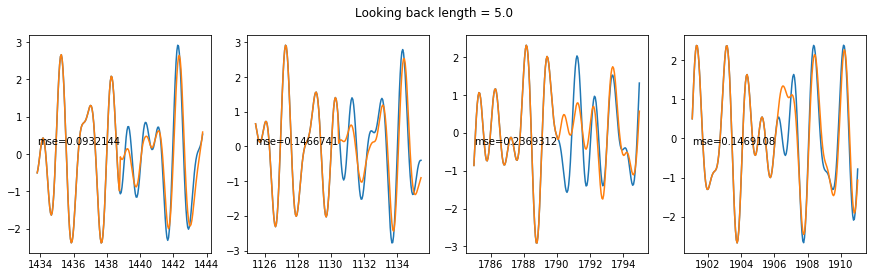

In [10]:
clusters([0.5, 0.7, 0.9], parameters=[2000, 100, 100])

With only one sine function, period list = [0.5, 0.7, 0.9, 1.1, 1.3].

The most complicated case will have largest deviation.

looking back of length : 2.5
period list is [0.5, 0.7, 0.9, 1.1, 1.3]


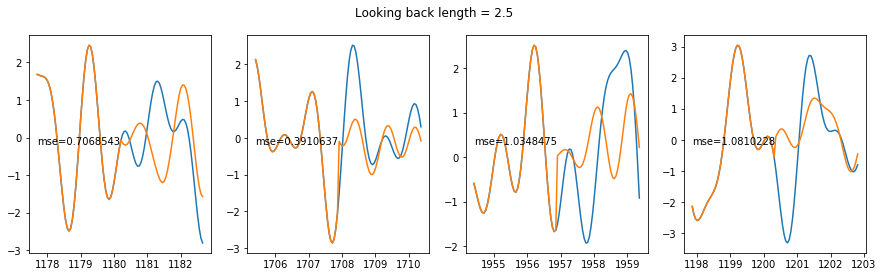

In [11]:
clusters([0.5, 0.7, 0.9, 1.1, 1.3])

Still with 5 sine functins, period list = [0.5, 0.7, 0.9, 1.1, 1.3]. With more finite time steps, it does not change much.




looking back of length : 2.5
period list is [0.5, 0.7, 0.9, 1.1, 1.3]


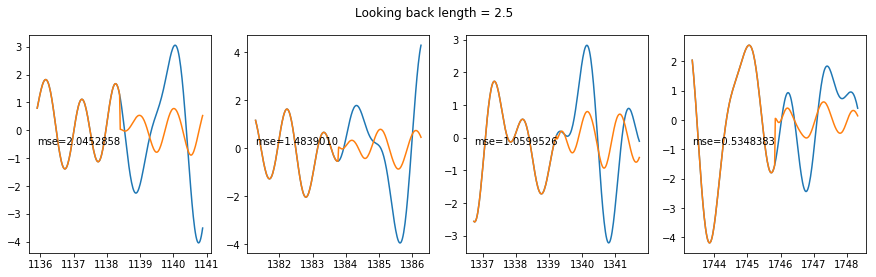

In [13]:
clusters([0.5, 0.7, 0.9, 1.1, 1.3], parameters=[5000, 100, 125])

Still with 5 sine functins, period list = [0.5, 0.7, 0.9, 1.1, 1.3]. With more sample space, it doesn't change much either.

looking back of length : 2.5
period list is [0.5, 0.7, 0.9, 1.1, 1.3]


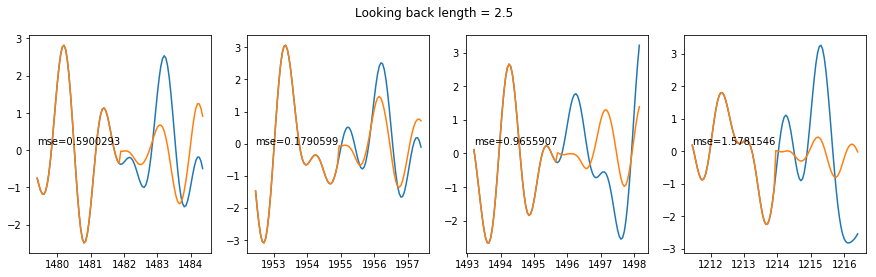

In [17]:
clusters([0.5, 0.7, 0.9, 1.1, 1.3], parameters=[12000, 600, 50])